In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
(X_train,_) , (_,_) = mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [0]:
X_train = X_train.reshape((-1,28*28))

In [5]:
X_train.shape

(60000, 784)

In [0]:
EPOCHS = 60
INPUT_SHAPE = 100
BATCH_SIZE = 256
HALF_BATCH_SIZE = 128
NO_OF_STEPS = int(X_train.shape[0]/BATCH_SIZE)
adam = Adam(lr=2e-4,beta_1=0.5)


In [7]:
# Normalize 
X_train = (X_train.astype('float32')-127.5)/127.5
print(np.min(X_train))
print(np.max(X_train))

-1.0
1.0


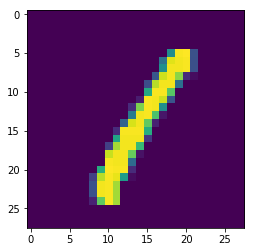

In [8]:
plt.imshow(np.reshape(X_train[3],(28,28)))

# **Generator**

In [9]:
generator = Sequential()
generator.add(Dense(256,input_dim = INPUT_SHAPE))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784))
generator.add(Activation('tanh'))



generator.compile(loss = 'binary_crossentropy',optimizer = adam)
generator.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_____________________

# **Discriminator**

In [10]:
discriminator =  Sequential()
discriminator.add(Dense(512,input_dim = 784))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))


discriminator.compile(loss = 'binary_crossentropy',optimizer =adam)
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
________________________________________________

# **Combined model (generator + discriminator)**

In [11]:
discriminator.trainable = False
gan_input = Input(shape = (INPUT_SHAPE,))
generator_output = generator(gan_input)
gan_output = discriminator(generator_output)
model = Model(input = gan_input,output = gan_output)

model.compile(loss = 'binary_crossentropy',optimizer = adam)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 533505    
Total params: 2,019,857
Trainable params: 1,486,352
Non-trainable params: 533,505
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  """


In [0]:
def showimgs():
  noise = np.random.normal(0,1,(100,INPUT_SHAPE))
  generated_imgs = generator.predict(noise)
  generated_imgs = np.reshape(generated_imgs,(-1,28,28))
  
  plt.figure(figsize = (10,10))
  for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(generated_imgs[i],cmap = 'gray',interpolation = 'nearest')
    plt.axis('off')
  plt.tight_layout()
  plt.show()
  

In [13]:
d_losses = []
g_losses = []


for epoch in range(EPOCHS):
    d_loss = 0.0
    g_loss = 0.0

    for j in range(NO_OF_STEPS):
        #training discriminator
        idx = np.random.randint(0,60000,HALF_BATCH_SIZE)
        real_imgs = X_train[idx]

        noise = np.random.normal(0,1,(HALF_BATCH_SIZE,INPUT_SHAPE))
        fake_imgs = generator.predict(noise)

        real_label = np.ones((128,1))*0.9
        fake_label = np.zeros((128,1))

        real_loss = discriminator.train_on_batch(real_imgs,real_label)
        fake_loss = discriminator.train_on_batch(fake_imgs,fake_label)

        d_loss += (0.5*real_loss + 0.5*fake_loss)

        #generator_loss
        noise = np.random.normal(0,1,(BATCH_SIZE,INPUT_SHAPE))
        real_g_label = np.ones((256,1))
        g_loss += model.train_on_batch(noise,real_g_label)


      
    d_losses.append(d_loss)
    g_losses.append(g_loss)


    print("Epoch %d D Loss %.4f G loss %0.4f "%((epoch+1),d_loss,g_loss))
    if (epoch%5)==0:
          showimgs()

Output hidden; open in https://colab.research.google.com to view.